### Analysis description
Here we aim at drawing all pycortex flatmaps for the GLM analysis matching paper of Fabius et al.<br/>
- [x] make flatmap
- [ ] make comparison as Gilles

In [4]:
# Imports
import os
import numpy as np
import nibabel as nb
import shutil
import warnings
import cortex
import re
import time
import matplotlib.pyplot as plt
from pycortex_utils import draw_cortex
from pathlib import Path
warnings.filterwarnings('ignore')

# Define parameters
subjects = ['sub-001','sub-002','sub-003','sub-004',
            'sub-005','sub-006','sub-007','sub-008']
tasks = ['AttendStimGazeLeft',
         'AttendStimGazeRight',
         'AttendFixGazeLeft',
         'AttendFixGazeRight']

# Define folders
base_dir = '/home/mszinte/disks/meso_S/data/gaze_prf'
bids_dir = "{}".format(base_dir)
pp_dir = "{}/derivatives/pp_data".format(base_dir)
pycortex_dir = "{}/cortex".format(pp_dir)

# Plot parameters
cmap_glm = 'plasma'
save_svg = False
xfm_name = 'identity.fmriprep'
beta_range = [0, 2]
alpha_range = [0, 0.4]
recache = False
inflated_maps_names = ['AttendBarGazeLeft_beta','AttendBarGazeRight_beta','AttendStimGazeLeft_beta','AttendStimGazeLeft_beta']

In [5]:
# Write pycortex config file
pycortex_db = "{}/db/".format(pycortex_dir)
pycortex_cm = "{}/colormaps/".format(pycortex_dir)
pycortex_config_file  = cortex.options.usercfg
pycortex_config_file_new = pycortex_config_file[:-4] + '_new.cfg'
pycortex_config_file_old = pycortex_config_file[:-4] + '_old.cfg'

Path(pycortex_config_file_new).touch()
with open(pycortex_config_file, 'r') as fileIn:
    with open(pycortex_config_file_new, 'w') as fileOut:
        for line in fileIn:
            if 'filestore' in line:
                newline = 'filestore=' + pycortex_db
                fileOut.write(newline)
                newline = '\n'
            elif 'colormaps' in line:
                newline = 'colormaps=' + pycortex_cm
                fileOut.write(newline)
                newline = '\n'
            else:
                newline = line
            fileOut.write(newline)
os.rename(pycortex_config_file,pycortex_config_file_old)
os.rename(pycortex_config_file_new, pycortex_config_file)

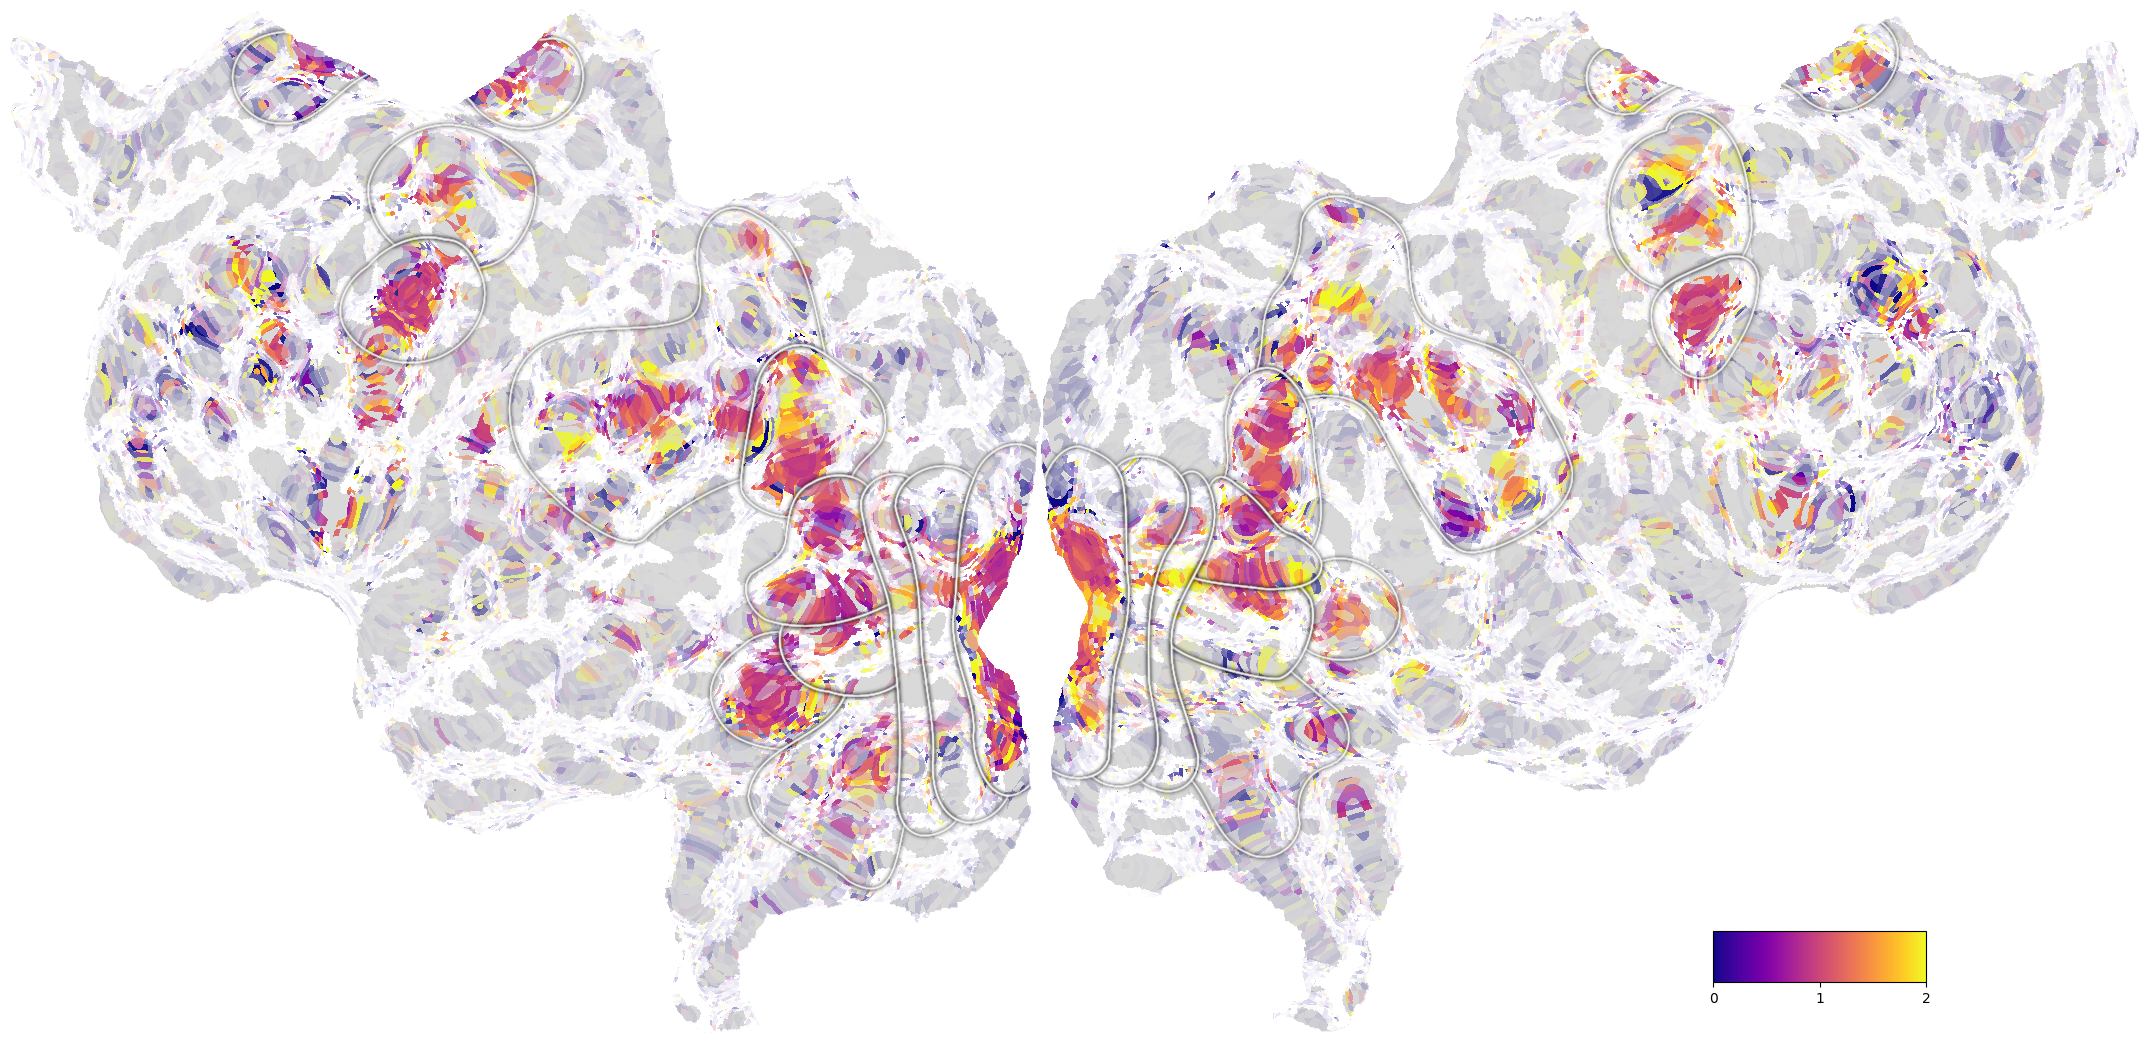

In [ ]:
for subject in subjects: 
    maps_names = []
    volumes = {}
    exec('{}_volumes = {{}}'.format(re.sub('-','_',subject)))
    for task in tasks:

        print(task)

        # Define and create folder
        fit_dir = '{}/{}/glm/fit'.format(pp_dir, subject)
        r2_dir = '{}/{}/prf/fit'.format(pp_dir, subject)
        mask_dir = '{}/{}/masks'.format(pp_dir, subject)
        flatmaps_dir = '{}/{}/glm/flatmaps'.format(pp_dir, subject)
        try: os.makedirs(flatmaps_dir) 
        except: pass

        # load pRF threshold masks
        th_fn = '{}/{}_task-FullScreen_prf_threshold.nii.gz'.format(mask_dir,subject,task)
        th_mat = nb.load(th_fn).get_fdata()
        th_mat[np.isnan(th_mat)] = 0 # replace it by 0 for alpha maps

        # Load fit parameters
        r2_im = nb.load('{}/{}_task-FullScreen_par-r2.nii.gz'.format(r2_dir,subject,task))
        beta_im = nb.load('{}/{}_task-{}_beta.nii.gz'.format(fit_dir,subject,task))

        # Create param matrix
        r2_idx, beta_idx = 0, 1
        param_mat = np.zeros((r2_im.shape[0],r2_im.shape[1],r2_im.shape[2],2))*np.nan
        param_mat[..., r2_idx] = r2_im.get_fdata()*th_mat # mask it by pRF threshold
        param_mat[..., beta_idx] = beta_im.get_fdata()

        # Define beta map
        r2_data = param_mat[...,r2_idx]
        alpha = (r2_data - alpha_range[0])/(alpha_range[1]-alpha_range[0])
        alpha[alpha>1]=1
        beta_param = {'data': param_mat[...,beta_idx], 'cmap': cmap_glm, 'alpha': alpha, 'vmin': beta_range[0], 'vmax': beta_range[1],
                      'cbar': 'discrete', 'description': '{} beta'.format(task), 'curv_brightness': 1, 
                      'curv_contrast': 0.3, 'add_roi': save_svg, 'subject': subject, 'xfmname': xfm_name}
        exec('{}_beta_param = beta_param'.format(task))
        maps_names.append('{}_beta'.format(task))

    # Flatmaps
    for maps_name in maps_names:
        exec('{}_volume, fig = draw_cortex(**{}_param)'.format(maps_name,maps_name))
        print("{}_task-{}".format(subject, maps_name))
        exec("plt.savefig('{}/{}_task-{}.pdf')".format(flatmaps_dir, subject, maps_name))
        plt.show()
        exec('vol_description = {}_param["description"]'.format(maps_name))
        exec('volume = {}_volume'.format(maps_name))
        volumes.update({vol_description:volume})

